In [18]:
import pickle
import numpy as np
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import *
from sklearn.cross_validation import train_test_split
import tensorflow as tf
import model_entropy
import model_huber
import time
import pandas as pd
import os
import nltk
from nltk.corpus import stopwords
stopword = list(set(stopwords.words('english')))

def clearstring(string):
    string = ' '.join(nltk.word_tokenize(string))
    string = re.sub('[^A-Za-z\- ]+', '', string)
    string = string.split(' ')
    string = filter(None, string)
    string = [y.strip() for y in string]
    return ' '.join([y for y in string if len(y) > 3 and y.find('nbsp') < 0 and y not in stopword]).lower()

In [5]:
with open('svm-model.p', 'rb') as fopen:
    svm=pickle.load(fopen)
with open('bayes-model.p', 'rb') as fopen:
    bayes=pickle.load(fopen)
with open('gb-model.p', 'rb') as fopen:
    gb=pickle.load(fopen)
with open('ada-model.p', 'rb') as fopen:
    ada=pickle.load(fopen)
with open('stack-model.p', 'rb') as fopen:
    clf=pickle.load(fopen)
with open('tfidf.p', 'rb') as fopen:
    tfidf=pickle.load(fopen)

In [7]:
with open('word-list.p', 'rb') as fopen:
    vocab = pickle.load(fopen)
with open('vector.p', 'rb') as fopen:
    vectors = pickle.load(fopen)
with open('dataset.p', 'rb') as fopen:
    df = pickle.load(fopen)
label = ['negative', 'positive']

In [9]:
tf.reset_default_graph()
huber_graph = tf.Graph()
with huber_graph.as_default():
    huber_model = model_huber.Model(3, 256, 128, 2, 0.0001)
    huber_sess = tf.InteractiveSession()
    huber_sess.run(tf.global_variables_initializer())
    saver = tf.train.Saver(tf.global_variables())
    saver.restore(huber_sess, os.getcwd() + "/rnn-huber.ckpt")

entropy_graph = tf.Graph()
with entropy_graph.as_default():
    entropy_model = model_entropy.Model(3, 256, 128, 2, 0.0001)
    entropy_sess = tf.InteractiveSession()
    entropy_sess.run(tf.global_variables_initializer())
    saver = tf.train.Saver(tf.global_variables())
    saver.restore(entropy_sess, os.getcwd() + "/rnn-entropy.ckpt")

INFO:tensorflow:Restoring parameters from /home/husein/space/text-dataset/news/rnn-huber.ckpt
INFO:tensorflow:Restoring parameters from /home/husein/space/text-dataset/news/rnn-entropy.ckpt


In [39]:
def classify(text, title=False):
    if title:
        text = [clearstring(text)]
    else:
        text = [clearstring(i) for i in list(filter(None, text.split('\n\n')))]
    if len(text) == 0:
        raise Exception('len text is zero')
    batch_x = np.zeros((len(text), 40, 128))
    for i in range(len(text)):
        tokens = text[i].split()[:40]
        for no, t in enumerate(tokens[::-1]):
            try:
                batch_x[i, -1 - no, :] += vectors[vocab.index(t), :]
            except Exception as e:
                continue
    huber_prob = huber_sess.run(tf.nn.softmax(huber_model.logits), feed_dict = {huber_model.X : batch_x})
    entropy_prob = entropy_sess.run(tf.nn.softmax(entropy_model.logits), feed_dict = {entropy_model.X : batch_x})
    batch_x = tfidf.transform(text)
    stack_train = np.hstack([svm.predict_proba(batch_x),
                             bayes.predict_proba(batch_x),
                             gb.predict_proba(batch_x), 
                             ada.predict_proba(batch_x),
                             huber_prob, entropy_prob])
    predict=clf.predict(stack_train)
    negative = np.where(predict==0)[0].shape[0]
    positive = np.where(predict==1)[0].shape[0]
    if title:
        return {'negative title':negative, 'positive title':positive}
    else:
        return {'negative':negative, 'positive':positive}

In [40]:
with open('data-crawl','rb') as fopen:
    dataset=pickle.load(fopen)

In [41]:
for i in reversed(range(len(dataset))):
    try:
        dataset[i].update(classify(dataset[i]['text'], title=False))
        dataset[i].update(classify(dataset[i]['title'], title=True))
    except Exception as e:
        print(e)
        del dataset[i]

len text is zero
len text is zero
len text is zero
len text is zero
len text is zero
len text is zero
len text is zero
len text is zero
len text is zero
len text is zero
len text is zero
len text is zero
len text is zero
len text is zero
len text is zero
len text is zero
len text is zero
len text is zero
len text is zero
len text is zero
len text is zero
len text is zero


In [80]:
import pandas as pd
df = pd.DataFrame(dataset)
df.date = pd.to_datetime(df.date)
df=df.sort_values(by='date')
df.negative = df.negative + df['negative title']
df.positive = df.positive + df['positive title']
df = df.drop(['negative title','positive title','text','title'],axis=1)
df=df.groupby(df.date).sum()
df['date'] = df.index
df = df[['date','negative','positive']]
df.head()

,date,negative,positive
date,,,
2010-01-14,2010-01-14,8,8
2010-01-26,2010-01-26,17,11
2010-05-06,2010-05-06,8,11
2010-07-01,2010-07-01,0,3
2010-07-03,2010-07-03,16,12


In [77]:
historical_date=df.date.dt.strftime(date_format='%d-%m-%Y').tolist()

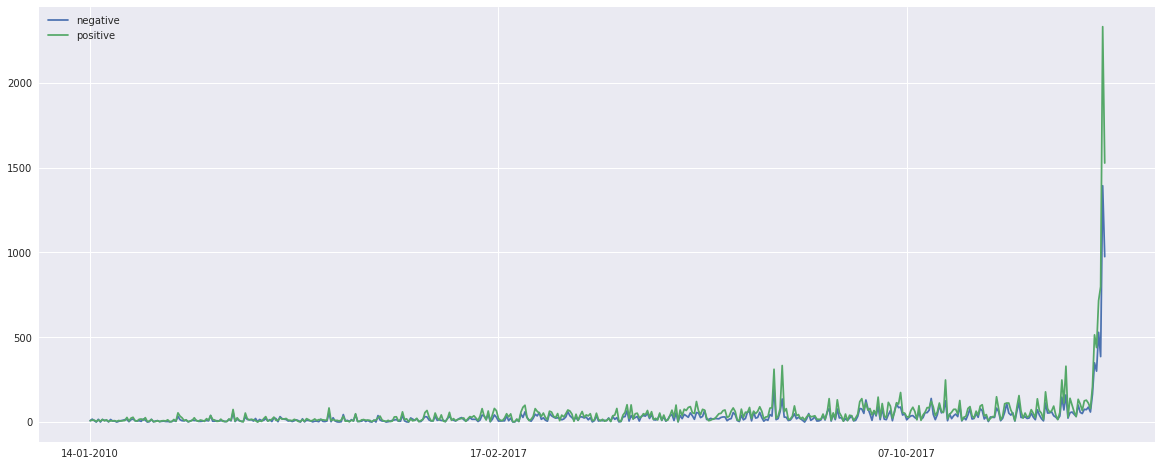

In [78]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
fig = plt.figure(figsize = (20,8))
plt.plot(np.arange(df.shape[0]), df.negative.values, label='negative')
plt.plot(np.arange(df.shape[0]), df.positive.values, label='positive')
plt.legend()
plt.xticks(np.arange(df.shape[0])[::200], historical_date[::200])
plt.show()

In [81]:
df.to_csv('sentiment.csv',index=False)